# Final Project for AI 221

AI 221 | 1st Sem AY 2024-2025  
Students: Jemima Bian Anila, Joshua Cantor, Michael Spencer Quinto, MEng in AI  
Instructors: Dr. Miguel Remolona | Dr. Jon Dewitt Dalisay

## Dataset

https://data.mendeley.com/datasets/tsvdyhbphs/1

https://www.kaggle.com/datasets/jaydepaolomirandilla/philippine-medicinal-plant-leaf-dataset/data


In [1]:
import sys
from pathlib import Path
  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import torch  
import cv2
import random



%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3)

/tmp/ipykernel_2236155/1189830066.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Add project root directory to Python path to allow importing from src folder
notebook_dir = Path("__file__").resolve().parent
project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [3]:
print(torch.cuda.is_available())

True


# Import utility modules from `src` folder

Note: all reusable code like transformations for the dataframes, etc. can be found inside the `src` folder and are imported here for better modularity and version control


In [4]:
from src.utils_nn import SampleNN, test_function
from src.utils_image_conversion import (
    PROCESSED_DATA_FOLDER,
    HIBISCUS_PROCESSED_FOLDER,
    CARMONA_RETUSA_PROCESSED_FOLDER,
    AVERRHOEA_BILIMBI_PROCESSED_FOLDER,
)
from src.utils_preprocessing import detect_edges_and_lines

In [5]:
print(PROCESSED_DATA_FOLDER.relative_to(project_root))
print(HIBISCUS_PROCESSED_FOLDER.relative_to(project_root))

data/ph_med_plants_reduced_sizes
data/ph_med_plants_reduced_sizes/1Hibiscus rosa-sinensis(HRS)


# 1. Exploratory Data Analysis


## 1.1 Data Loading and Inspection


In [6]:
# Get list of files in HIBISCUS_PROCESSED_FOLDER
hibiscus_files = list(HIBISCUS_PROCESSED_FOLDER.glob("*.webp"))
hibiscus_files_names = [file.name for file in hibiscus_files]
print(hibiscus_files_names)

['Class1_19.webp', 'Class1_93.webp', 'Class1_3.webp', 'Class1_37.webp', 'Class1_80.webp', 'Class1_17.webp', 'Class1_23.webp', 'Class1_22.webp', 'Class1_25.webp', 'Class1_39.webp', 'Class1_33.webp', 'Class1_95.webp', 'Class1_16.webp', 'Class1_115.webp', 'Class1_49.webp', 'Class1_32.webp', 'Class1_110.webp', 'Class1_108.webp', 'Class1_84.webp', 'Class1_111.webp', 'Class1_116.webp', 'Class1_7.webp', 'Class1_77.webp', 'Class1_69.webp', 'Class1_73.webp', 'Class1_89.webp', 'Class1_63.webp', 'Class1_58.webp', 'Class1_105.webp', 'Class1_18.webp', 'Class1_75.webp', 'Class1_106.webp', 'Class1_112.webp', 'Class1_27.webp', 'Class1_11.webp', 'Class1_52.webp', 'Class1_34.webp', 'Class1_104.webp', 'Class1_35.webp', 'Class1_65.webp', 'Class1_102.webp', 'Class1_76.webp', 'Class1_97.webp', 'Class1_44.webp', 'Class1_72.webp', 'Class1_1.webp', 'Class1_42.webp', 'Class1_38.webp', 'Class1_28.webp', 'Class1_6.webp', 'Class1_30.webp', 'Class1_62.webp', 'Class1_81.webp', 'Class1_96.webp', 'Class1_114.webp', 'C

In [7]:
# Total number of (all ) images
# Get total number of images across all classes
# Get total number of images across all subfolders
total_images = sum(
    len(list(folder.glob("*.webp")))
    for folder in PROCESSED_DATA_FOLDER.iterdir()
    if folder.is_dir()
)
print(f"Total number of images: {total_images}")
print("--------------------------------")

# Get number of images per subfolder
for folder in PROCESSED_DATA_FOLDER.iterdir():
    if folder.is_dir():
        num_images = len(list(folder.glob("*.webp")))
        print(f"{folder.name}: {num_images} images")

print("--------------------------------")
# Get total number of folders
num_folders = sum(1 for folder in PROCESSED_DATA_FOLDER.iterdir() if folder.is_dir())
print(f"\nTotal number of folders: {num_folders}")

Total number of images: 4971
--------------------------------
8Pepromia pellucida(PP): 140 images
29Premna odorata(PO): 120 images
39Manihot esculenta(ME): 124 images
17Senna alata(SA): 118 images
33Citrus microcarpa(CM): 110 images
35Arachis hypogaea(AH): 130 images
10Coleus scutellarioides(CS): 120 images
23Pandanus amaryllifolius(PA): 108 images
1Hibiscus rosa-sinensis(HRS): 116 images
26Averrhoea bilimbi(AVB): 100 images
24Aloe barbadensis Miller(ABM): 130 images
16Carmona retusa(CR): 130 images
32Mangifera indica(MI): 110 images
22Nerium oleander(NO): 130 images
19Capsicum frutescens(CF): 126 images
4Vitex negundo(VN): 146 images
40Citrus maxima(CMA): 130 images
25Lagerstroemia speciosa(LS): 140 images
27Annona muricata(AM): 120 images
2Psidium guajava(PG): 110 images
30Gliricidia sepium(GS): 130 images
38Ipomoea batatas(IPB): 110 images
3Antidesma bunius(AB): 142 images
6Blumea balsamifera(BB): 110 images
28Citrus aurantiifolia(CIA): 116 images
21Ocimum basilicum(OB): 148 images


## 9 Random Hibiscus Images


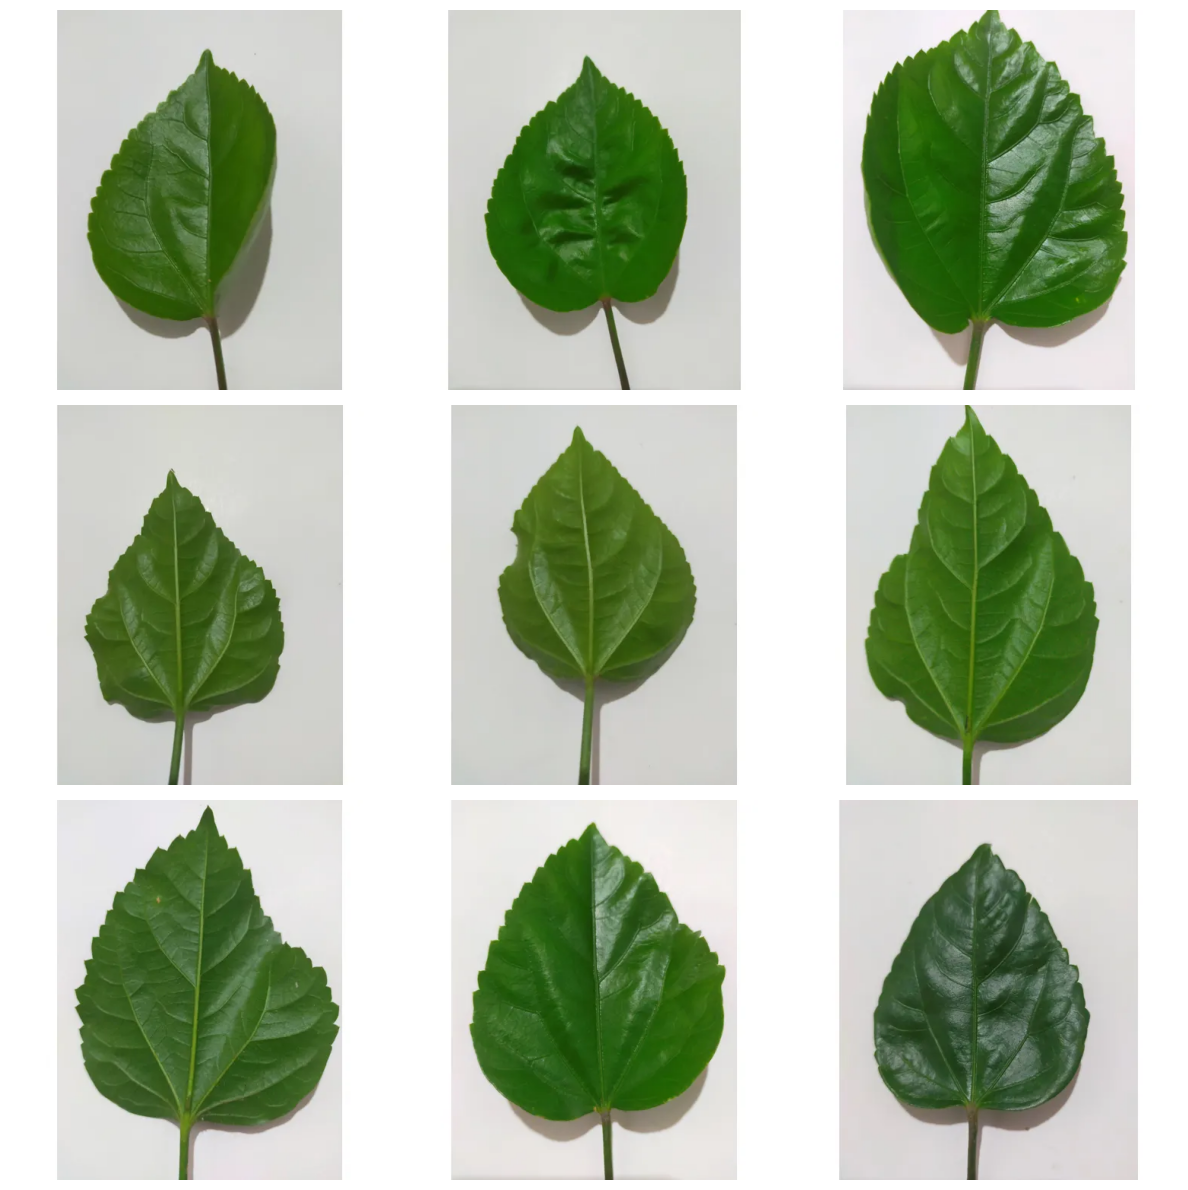

In [8]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Randomly sample 9 images
random_images = random.sample(hibiscus_files, 9)

# Plot each image
for idx, ax in enumerate(axes.flat):
    img = plt.imread(random_images[idx])
    ax.imshow(img)
    ax.axis("off")

# Adjust layout and display
plt.tight_layout()
plt.show()

## 9 random averrhoea bilimbi images


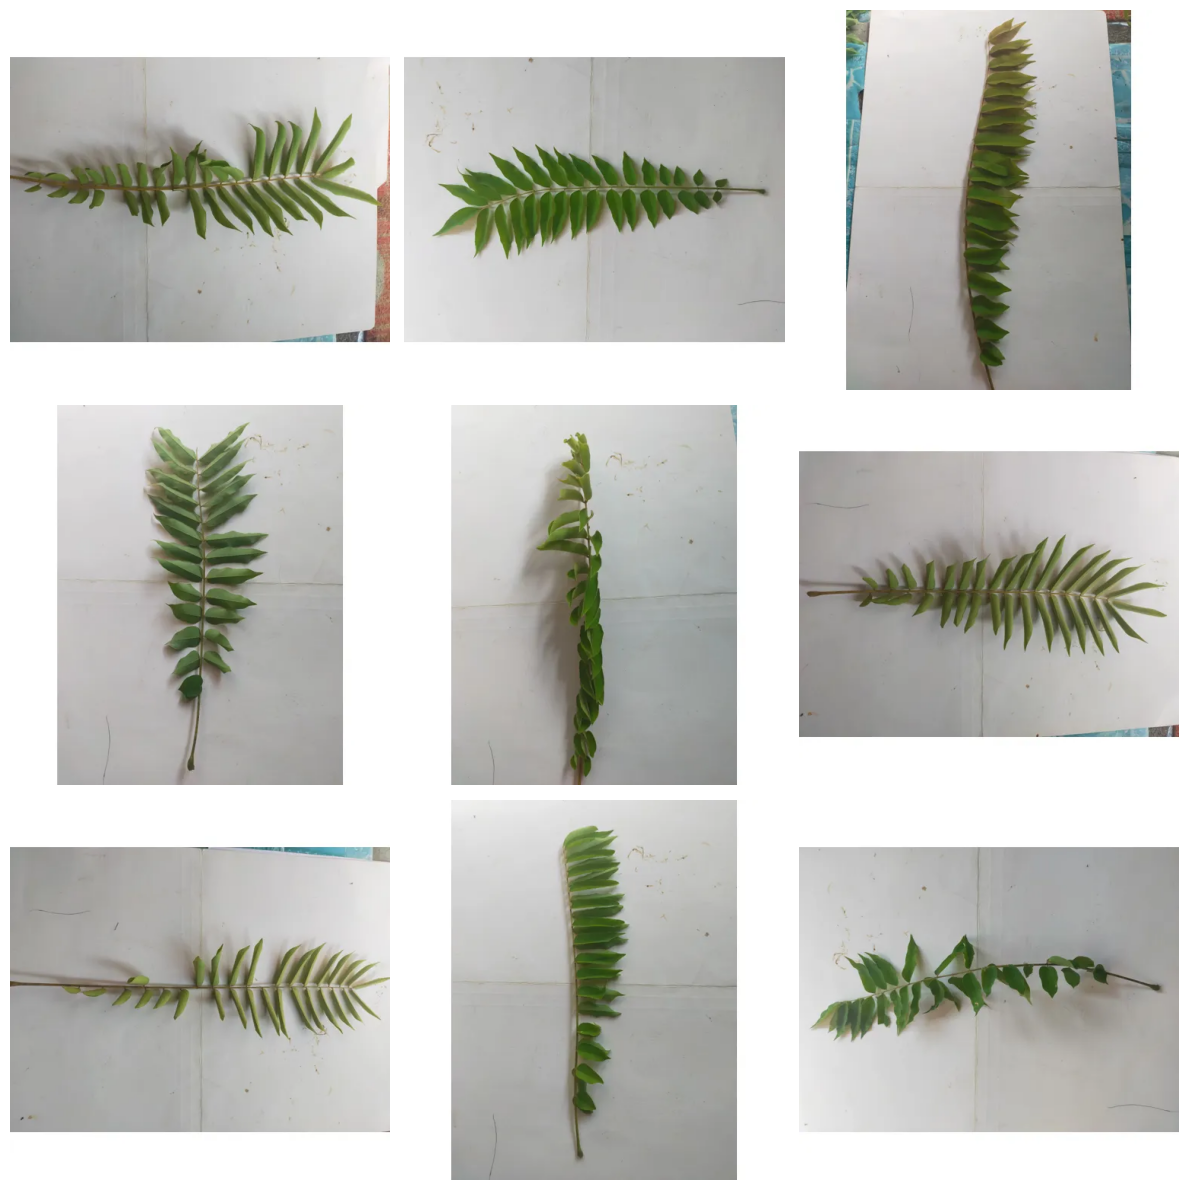

In [9]:
averrhoea_bilimbi_files = list(AVERRHOEA_BILIMBI_PROCESSED_FOLDER.glob("*.webp"))

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Randomly sample 9 images
random_images = random.sample(averrhoea_bilimbi_files, 9)

# Plot each image
for idx, ax in enumerate(axes.flat):
    img = plt.imread(random_images[idx])
    ax.imshow(img)
    ax.axis("off")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [28]:
# Get all class folders in the processed data directory
class_folders = list(PROCESSED_DATA_FOLDER.glob("*"))
class_folders_names = sorted([folder.name for folder in class_folders])


print("Folders in the processed data directory:")
for folder in class_folders_names:
    print(f"{folder}")

Folders in the processed data directory:
10Coleus scutellarioides(CS)
11Phyllanthus niruri(PN)
12Corchorus olitorius(CO)
13Momordica charantia (MC)
14Euphorbia hirta(EH)
15Curcuma longa(CL)
16Carmona retusa(CR)
17Senna alata(SA)
18Mentha cordifolia Opiz(MCO)
19Capsicum frutescens(CF)
1Hibiscus rosa-sinensis(HRS)
20Jatropha curcas(JC)
21Ocimum basilicum(OB)
22Nerium oleander(NO)
23Pandanus amaryllifolius(PA)
24Aloe barbadensis Miller(ABM)
25Lagerstroemia speciosa(LS)
26Averrhoea bilimbi(AVB)
27Annona muricata(AM)
28Citrus aurantiifolia(CIA)
29Premna odorata(PO)
2Psidium guajava(PG)
30Gliricidia sepium(GS)
31Citrus sinensis(CIS)
32Mangifera indica(MI)
33Citrus microcarpa(CM)
34Impatiens balsamina(IB)
35Arachis hypogaea(AH)
36Tamarindus indica(TI)
37Leucaena leucocephala(LL)
38Ipomoea batatas(IPB)
39Manihot esculenta(ME)
3Antidesma bunius(AB)
40Citrus maxima(CMA)
4Vitex negundo(VN)
5Moringa oleifera(MO)
6Blumea balsamifera(BB)
7Origanum vulgare(OV)
8Pepromia pellucida(PP)
9Centella asiati

In [29]:
from src.utils_data import LIST_OF_FOLDER_CLASSES

print(LIST_OF_FOLDER_CLASSES)

['1Hibiscus rosa-sinensis(HRS)', '2Psidium guajava(PG)', '3Antidesma bunius(AB)', '4Vitex negundo(VN)', '5Moringa oleifera(MO)', '6Blumea balsamifera(BB)', '7Origanum vulgare(OV)', '8Pepromia pellucida(PP)', '9Centella asiatica(CA)', '10Coleus scutellarioides(CS)', '11Phyllanthus niruri(PN)', '12Corchorus olitorius(CO)', '13Momordica charantia (MC)', '14Euphorbia hirta(EH)', '15Curcuma longa(CL)', '16Carmona retusa(CR)', '17Senna alata(SA)', '18Mentha cordifolia Opiz(MCO)', '19Capsicum frutescens(CF)', '20Jatropha curcas(JC)', '21Ocimum basilicum(OB)', '22Nerium oleander(NO)', '23Pandanus amaryllifolius(PA)', '24Aloe barbadensis Miller(ABM)', '25Lagerstroemia speciosa(LS)', '26Averrhoea bilimbi(AVB)', '27Annona muricata(AM)', '28Citrus aurantiifolia(CIA)', '29Premna odorata(PO)', '30Gliricidia sepium(GS)', '31Citrus sinensis(CIS)', '32Mangifera indica(MI)', '33Citrus microcarpa(CM)', '34Impatiens balsamina(IB)', '35Arachis hypogaea(AH)', '36Tamarindus indica(TI)', '37Leucaena leucoceph

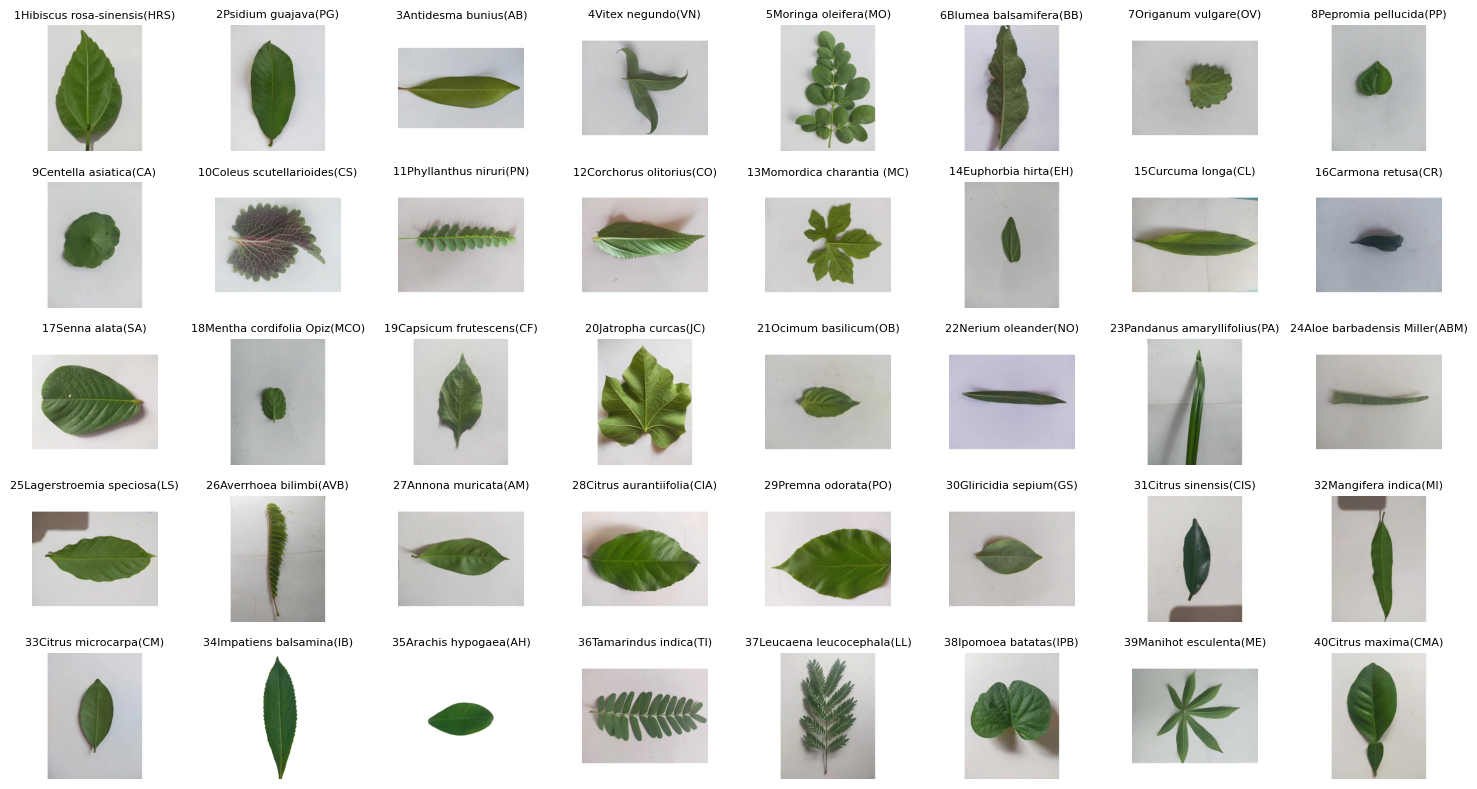

In [35]:
from src.utils_data import plot_random_images_grid

# Get one random image from each class folder
class_folders = [
    PROCESSED_DATA_FOLDER / folder_class for folder_class in LIST_OF_FOLDER_CLASSES
]


plot_random_images_grid(class_folders)
plot_random_images_grid(class_folders)

## Sample Image Processing


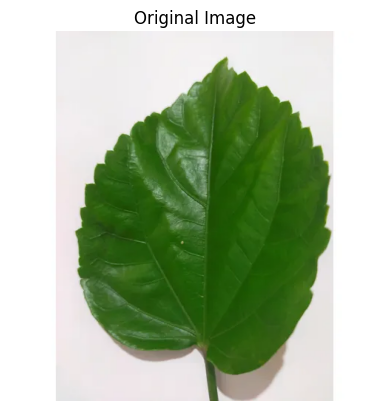

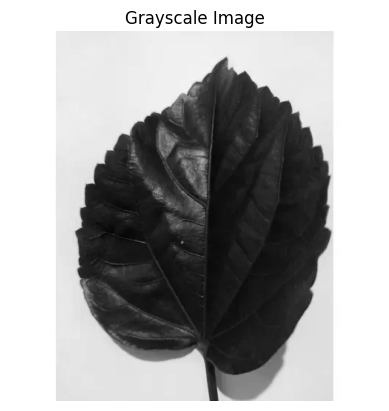

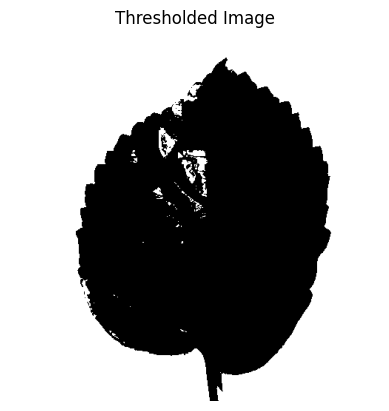

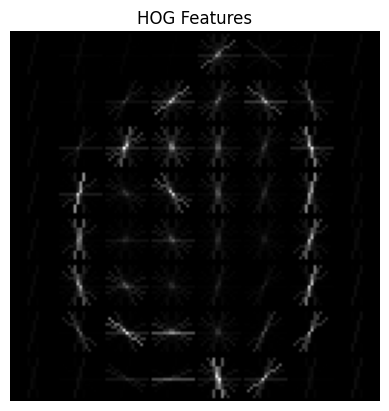

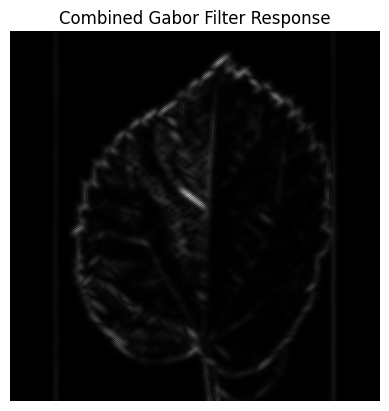

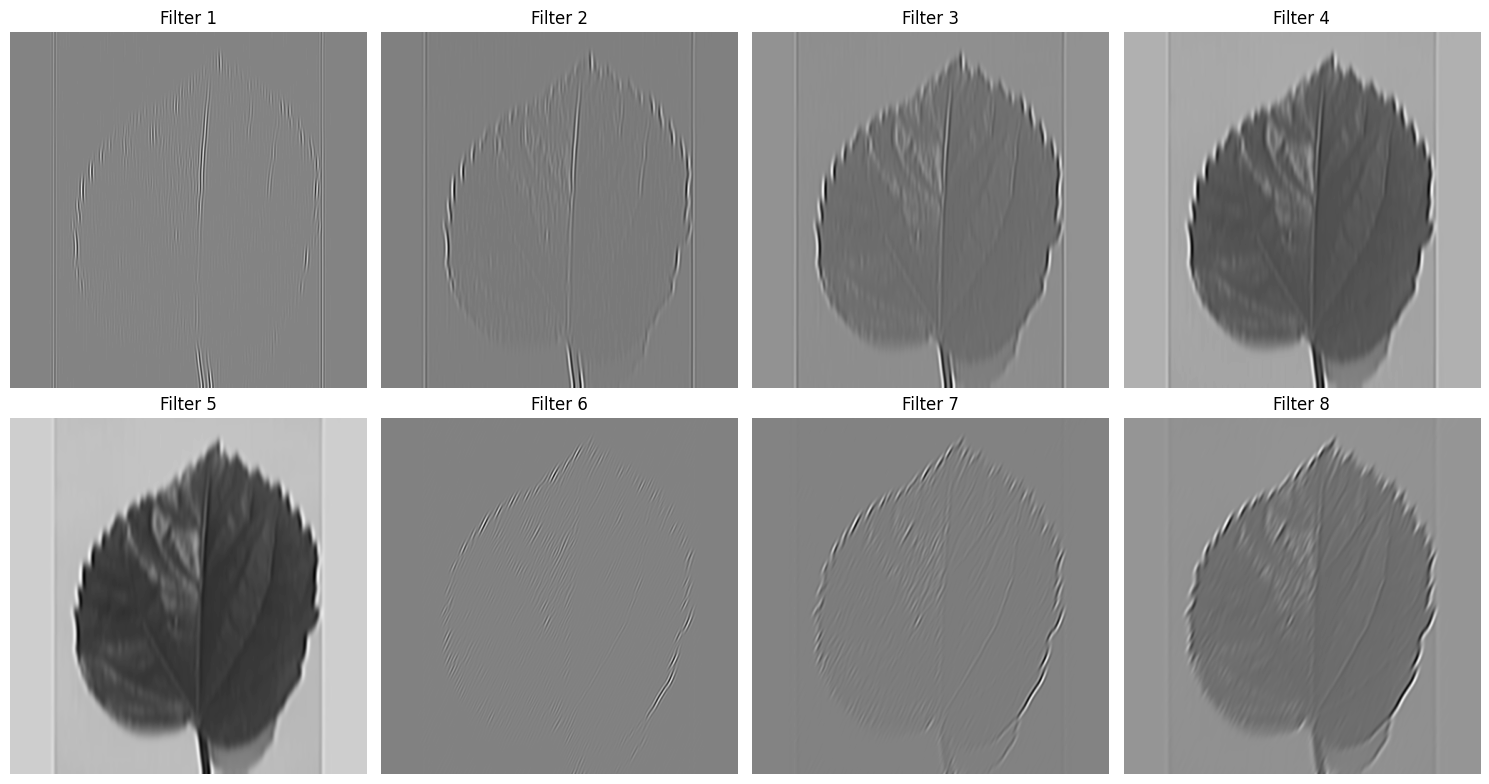

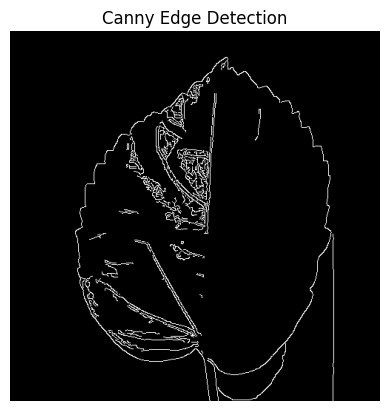

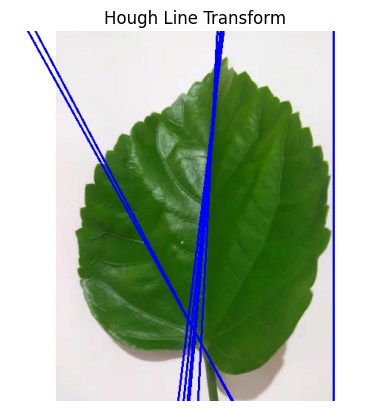

In [10]:
hibiscus_random = hibiscus_files[1]
sample_image = plt.imread(hibiscus_random)
plt.imshow(sample_image)
plt.axis("off")
plt.title("Original Image")
plt.show()

# Convert to grayscale and display
sample_img_gray = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(sample_img_gray, cmap="gray")
plt.axis("off")
plt.title("Grayscale Image")
plt.show()

# Apply thresholding and display
_, sample_img_thresh = cv2.threshold(sample_img_gray, 127, 255, cv2.THRESH_BINARY)
plt.figure()
plt.imshow(sample_img_thresh, cmap="gray")
plt.axis("off")
plt.title("Thresholded Image")
plt.show()

import skimage

# Histogram of Oriented Gradients (HOG)
# Calculate HOG features
pixels_per_cell = (16, 16)  # Size of cell for HOG computation
cells_per_block = (2, 2)  # Number of cells in each block
orientations = 9  # Number of orientation bins

# Resize image to ensure consistent dimensions for HOG
resized_img = cv2.resize(sample_img_gray, (128, 128))

# Calculate HOG features and visualization
hog_features, hog_image = skimage.feature.hog(
    resized_img,
    orientations=orientations,
    pixels_per_cell=pixels_per_cell,
    cells_per_block=cells_per_block,
    visualize=True,
    block_norm="L2-Hys",
)

# Display HOG visualization
plt.figure()
plt.imshow(hog_image, cmap="gray")
plt.axis("off")
plt.title("HOG Features")
plt.show()


# Apply Gabor filters for texture analysis
def build_gabor_filters() -> list[np.ndarray]:
    """Build Gabor filters with different orientations and frequencies.

    Returns:
        list[np.ndarray]: List of Gabor kernels
    """
    filters: list[np.ndarray] = []
    ksize: int = 31  # Kernel size
    sigma: float = 3.0  # Standard deviation of Gaussian envelope
    lambda_min: float = 4.0  # Minimum wavelength
    lambda_max: float = 10.0  # Maximum wavelength
    num_thetas: int = 8  # Number of orientations
    num_lambdas: int = 5  # Number of wavelengths

    # Generate filters for different orientations and wavelengths
    for theta in np.linspace(0, np.pi, num_thetas):
        for lambda_ in np.linspace(lambda_min, lambda_max, num_lambdas):
            kernel = cv2.getGaborKernel(
                (ksize, ksize),
                sigma=sigma,
                theta=theta,
                lambd=lambda_,
                gamma=0.5,  # Spatial aspect ratio
                psi=0,  # Phase offset
            )
            kernel /= 1.5 * kernel.sum()
            filters.append(kernel)
    return filters


def apply_gabor_filters(
    image: np.ndarray, filters: list[np.ndarray]
) -> tuple[np.ndarray, list[np.ndarray]]:
    """Apply Gabor filters to an image.

    Args:
        image: Input grayscale image
        filters: List of Gabor kernels

    Returns:
        tuple containing:
            - Combined filtered image
            - List of individual filter responses
    """
    responses: list[np.ndarray] = []
    for kernel in filters:
        response = cv2.filter2D(image, cv2.CV_32F, kernel)
        responses.append(response)

    # Combine responses
    combined = np.sqrt(
        np.sum(np.array([response**2 for response in responses]), axis=0)
    )
    return combined, responses


# Generate Gabor filters
gabor_filters = build_gabor_filters()

# Apply filters to grayscale image
gabor_combined, gabor_responses = apply_gabor_filters(sample_img_gray, gabor_filters)

# Display combined Gabor response
plt.figure()
plt.imshow(gabor_combined, cmap="gray")
plt.axis("off")
plt.title("Combined Gabor Filter Response")
plt.show()

# Display first few individual Gabor responses
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for idx, ax in enumerate(axes.flat[:8]):
    ax.imshow(gabor_responses[idx], cmap="gray")
    ax.axis("off")
    ax.set_title(f"Filter {idx+1}")
plt.tight_layout()
plt.show()


edges, line_image = detect_edges_and_lines(sample_image)

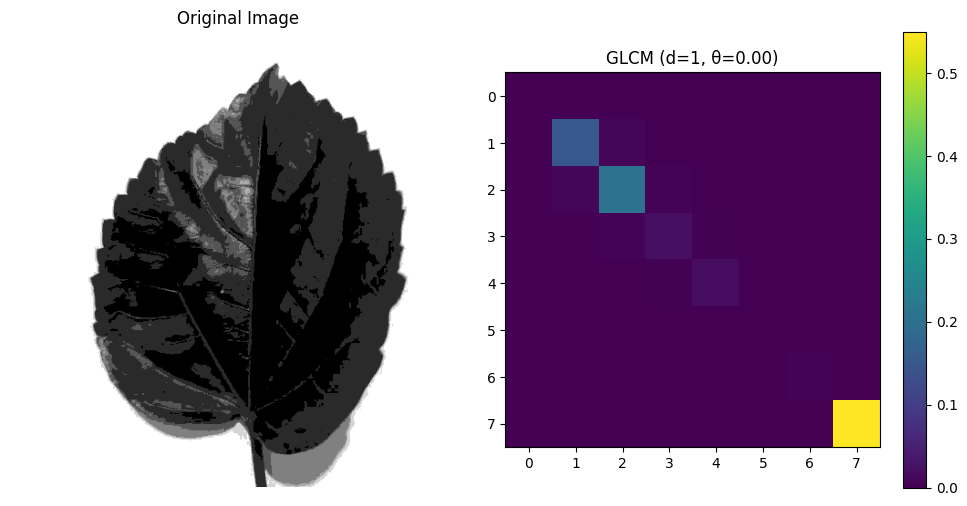

In [17]:
from skimage.feature import graycomatrix, graycoprops
from src.utils_preprocessing import extract_glcm_features, visualize_glcm

# sample_img_gray

glcm_features = extract_glcm_features(sample_img_gray)
visualize_glcm(sample_img_gray)